
# 🅿️ Smart Parking using Reinforcement Learning

This project implements a **Smart Parking System** using classic **Path Planning (BFS)** and **Deep Reinforcement Learning (DQN)** techniques.

## 📌 Problem
Design a system to guide an autonomous vehicle from the entrance of a parking lot to the most optimal parking spot, while avoiding randomly placed obstacles.

---

## 🧠 Approach
- **Custom Environment** simulating a parking lot with free and occupied spaces
- **Valid parking spots** predefined (goal positions)
- **Obstacles** placed randomly each episode
- **BFS** for deterministic pathfinding
- **DQN** for training a deep agent to learn parking behavior

---

## 📐 Environment Overview
- Grid-based 5x5 parking lot
- Actions: `Up`, `Down`, `Left`, `Right`, `Park`
- Rewards:
  - ✅ +20 for parking in a valid spot
  - ⚠️ +5 for parking in a non-goal free space
  - ❌ -5 for trying to park in an occupied space
  - 🚶‍♂️ -0.1 per step

---

## 🛠️ Technologies Used
- `Python`, `NumPy`, `PyTorch`
- `Pygame` for real-time visualization
- `Matplotlib` for path plotting

---

## 🎮 Demo
The agent starts from the top-left and finds its way to the nearest available **valid parking spot**, avoiding obstacles. You can run this multiple times to see different random layouts!

---



In [13]:
import pygame
import torch
import numpy as np

In [14]:
from collections import deque


In [15]:
class SmartParkingEnv:
    def __init__(self, size=5):
        self.size = size
        self.num_actions = 5  # up, down, left, right, park
        self.valid_parking_spots = [[4, 1], [3, 3], [2, 4]]
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.parking_slots = np.zeros((self.size, self.size), dtype=int)
        self.parking_slots[0, 0] = 1

        for x, y in self.valid_parking_spots:
            self.parking_slots[x, y] = 0

        count = 0
        while count < 5:
            x, y = np.random.randint(0, self.size, size=2)
            if [x, y] != [0, 0] and [x, y] not in self.valid_parking_spots and self.parking_slots[x, y] == 0:
                self.parking_slots[x, y] = 1
                count += 1

        self.steps = 0
        return self._get_state()

    def _get_state(self):
        flat_slots = self.parking_slots.flatten()
        state = self.agent_pos + flat_slots.tolist()
        return np.array(state, dtype=np.float32)

    def step(self, action):
        reward = -0.1
        done = False
        x, y = self.agent_pos

        if action == 0 and x > 0: x -= 1
        elif action == 1 and x < self.size - 1: x += 1
        elif action == 2 and y > 0: y -= 1
        elif action == 3 and y < self.size - 1: y += 1
        elif action == 4:
            if self.parking_slots[x, y] == 0:
                if [x, y] in self.valid_parking_spots:
                    reward = 20
                else:
                    reward = 5
                done = True
            else:
                reward = -5

        self.agent_pos = [x, y]
        self.steps += 1
        if self.steps >= 30:
            done = True

        return self._get_state(), reward, done, {}

In [16]:
import torch.nn as nn


In [17]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [18]:

def bfs_path(slots, start, goal):
    queue = deque([(start, [start])])
    visited = set()
    while queue:
        (x, y), path = queue.popleft()
        if (x, y) == goal:
            return path
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < slots.shape[0] and 0 <= ny < slots.shape[1]:
                if slots[nx, ny] == 0 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append(((nx, ny), path + [(nx, ny)]))
    return []

def find_nearest_parking(start, slots, valid_spots):
    best_path = []
    shortest = None
    for spot in valid_spots:
        path = bfs_path(slots, tuple(start), tuple(spot))
        if path and (shortest is None or len(path) < shortest):
            best_path = path
            shortest = len(path)
    return best_path


In [19]:
def visualize_path(env, path):
    pygame.init()
    width, height = 500, 500
    rows, cols = env.size, env.size
    slot_size = width // cols
    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption("Smart Parking - BFS Path")

    COLORS = {
        'car': (0, 0, 255),
        'parked': (0, 200, 0),
        'empty': (200, 255, 200),
        'occupied': (255, 100, 100),
        'grid': (220, 220, 220),
        'valid': (255, 255, 0)
    }

    def draw_env(pos):
        screen.fill(COLORS['grid'])
        for i in range(rows):
            for j in range(cols):
                rect = pygame.Rect(j * slot_size, i * slot_size, slot_size - 2, slot_size - 2)
                if env.parking_slots[i, j] == 1:
                    pygame.draw.rect(screen, COLORS['occupied'], rect)
                elif [i, j] in env.valid_parking_spots:
                    pygame.draw.rect(screen, COLORS['valid'], rect)
                else:
                    pygame.draw.rect(screen, COLORS['empty'], rect)

        if pos == path[-1]:
            pygame.draw.rect(screen, COLORS['parked'], pygame.Rect(pos[1] * slot_size, pos[0] * slot_size, slot_size - 2, slot_size - 2))
        else:
            pygame.draw.rect(screen, COLORS['car'], pygame.Rect(pos[1] * slot_size, pos[0] * slot_size, slot_size - 2, slot_size - 2))

        pygame.display.flip()

    for pos in path:
        draw_env(pos)
        pygame.time.wait(400)

    pygame.time.wait(800)
    pygame.quit()

In [20]:
import time


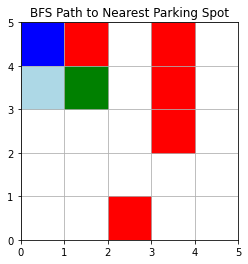

In [22]:
env = SmartParkingEnv()
state = env.reset()
start = env.agent_pos
path = find_nearest_parking(start, env.parking_slots, env.valid_parking_spots)

visualize_path(env, path)

obstacles = [(i, j) for i in range(env.size) for j in range(env.size) if env.parking_slots[i, j] == 1]
parking_spots = env.valid_parking_spots

plot_path_on_grid(env.size, path, obstacles, parking_spots)



In [23]:
import matplotlib.pyplot as plt

def plot_path_on_grid(grid_size, path, obstacles, parking_spots):
    grid = [['' for _ in range(grid_size)] for _ in range(grid_size)]
    
    for x, y in obstacles:
        grid[x][y] = 'X'
    for x, y in parking_spots:
        grid[x][y] = 'P'
    for i, (x, y) in enumerate(path):
        if i == 0:
            grid[x][y] = 'S'
        elif i == len(path) - 1:
            grid[x][y] = 'G'
        else:
            grid[x][y] = '*'

    fig, ax = plt.subplots()
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size+1))
    ax.set_yticks(range(grid_size+1))
    ax.grid(True)

    for i in range(grid_size):
        for j in range(grid_size):
            cell = grid[i][j]
            if cell == 'X':
                ax.add_patch(plt.Rectangle((j, grid_size-1-i), 1, 1, color='red'))
            elif cell == 'P':
                ax.add_patch(plt.Rectangle((j, grid_size-1-i), 1, 1, color='yellow'))
            elif cell == 'S':
                ax.add_patch(plt.Rectangle((j, grid_size-1-i), 1, 1, color='blue'))
            elif cell == 'G':
                ax.add_patch(plt.Rectangle((j, grid_size-1-i), 1, 1, color='green'))
            elif cell == '*':
                ax.add_patch(plt.Rectangle((j, grid_size-1-i), 1, 1, color='lightblue'))

    plt.title("BFS Path to Nearest Parking Spot")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


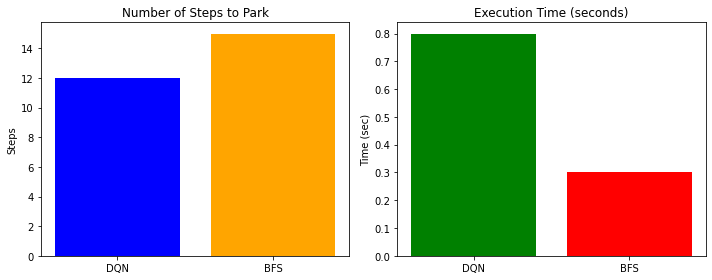

In [1]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['DQN', 'BFS']
steps = [12, 15]  
exec_time = [0.8, 0.3] 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.bar(methods, steps, color=['blue', 'orange'])
ax1.set_title('Number of Steps to Park')
ax1.set_ylabel('Steps')

ax2.bar(methods, exec_time, color=['green', 'red'])
ax2.set_title('Execution Time (seconds)')
ax2.set_ylabel('Time (sec)')

plt.tight_layout()
plt.show()


## 👤 Developed by
**راشین قلیجانی فراهانی**  
_ML Enthusiast | AI Engineer | RL Explorer_

---
